<a href="https://colab.research.google.com/github/sashwinbwaj/Netflix-Recommendation-System/blob/main/Netflix_Recommendation_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Recommendation system for Netflix ratings data
In this project, we use the famous 'Netflix Prize' dataset to experiment with out recommendation model. The focus is on collaborative filtering techniques which uses a combination of user-user similarities & user-item interaction in order to recommend. 

### 1.0 Loading & Cleaning ratings 

In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import io
from datetime import datetime 
import gc
import matplotlib.style as style 

from scipy import sparse
from scipy.sparse import csr_matrix

from surprise import Reader, Dataset
from surprise.model_selection import cross_validate, train_test_split
from surprise import SVD, SVDpp, NMF, NormalPredictor
from surprise.model_selection import GridSearchCV


In [ ]:
start = datetime.now()
data = open('data.csv', mode='w')
row = list()
files = ['combined_data_1.txt', 'combined_data_2.txt', 'combined_data_3.txt', 'combined_data_4.txt']
for file in files:
    print("Reading ratings from {}\n".format(file))
    with open(file) as f:
        for line in f: 
            line = line.strip()
            if line.endswith(':'):
                # All below are ratings for this movie, until another movie appears.
                movie_id = line.replace(':', '')
            else:
                row = [x for x in line.split(',')]
                row.insert(0, movie_id)
                data.write(','.join(row))
                data.write('\n')
data.close()
print('Time taken :', datetime.now() - start)

Reading ratings from combined_data_1.txt

Reading ratings from combined_data_2.txt

Reading ratings from combined_data_3.txt

Reading ratings from combined_data_4.txt

Time taken : 0:05:10.936732


In [ ]:
ratings = pd.read_csv('data.csv', sep=',', names = ['movie', 'customer', 'rating', 'date'])
ratings.date = pd.to_datetime(ratings.date)
ratings.head()

,movie,customer,rating,date
0,1,1488844,3,2005-09-06
1,1,822109,5,2005-05-13
2,1,885013,4,2005-10-19
3,1,30878,4,2005-12-26
4,1,823519,3,2004-05-03


In [ ]:
print(ratings.shape)
# Checking for missing values - There are no missing values
print(ratings.isna().sum())

(100480507, 4)
movie       0
customer    0
rating      0
date        0
dtype: int64


In [ ]:
dup_bool = ratings.duplicated()
ratings[dup_bool].shape

(0, 4)

In [ ]:
# Storing the indices of customers who rated less than 10 times as well as movies which were rated less than 50 times
# The threshold for low counts were decided after considering the domain as well as looking at the low count pool as a percentage of total data
movie_counts = pd.DataFrame(ratings['rating'].groupby(ratings['movie']).count())
low_count_movies = movie_counts.query('rating < 50').index
customer_counts = pd.DataFrame(ratings['rating'].groupby(ratings['customer']).count())
low_count_customers = customer_counts.query('rating < 20').index

In [ ]:
#Removing the low count pool from the ratings data
ratings_new = ratings[~ratings['customer'].isin(low_count_customers)]
ratings_new = ratings_new[~ratings_new['movie'].isin(low_count_movies)]

In [ ]:
print(f'Original ratings shape : {ratings.shape}')
print(f'Revised ratings shape : {ratings_new.shape}')

Original ratings shape : (100480507, 4)
Revised ratings shape : (96447729, 4)


In [ ]:
# Writing the ratings data to file
ratings_new['day'] = ratings_new.date.dt.day_name()
ratings_new.to_csv("netflix_ratings.csv", index=False)

### 2.0 Exploratory Data Analysis

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
ratings_new = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/netflix_ratings.csv', parse_dates = ['date'])
ratings_new.sort_values(by = ['date'], inplace = True)
ratings_new.head()

,movie,customer,rating,date,day
49894564,9392,510180,3,1999-11-11,Thursday
19710963,3870,510180,2,1999-11-11,Thursday
18932051,3730,510180,4,1999-11-11,Thursday
56528603,10774,510180,3,1999-11-11,Thursday
67988765,12818,510180,2,1999-11-11,Thursday


In [ ]:
# Basic stats
print(f'Unique users: {ratings_new.customer.nunique()}')
print(f'Unique movies: {ratings_new.movie.nunique()}')

Unique users: 480189
Unique movies: 17770


#### 2.0.1 Distribution of ratings across all users

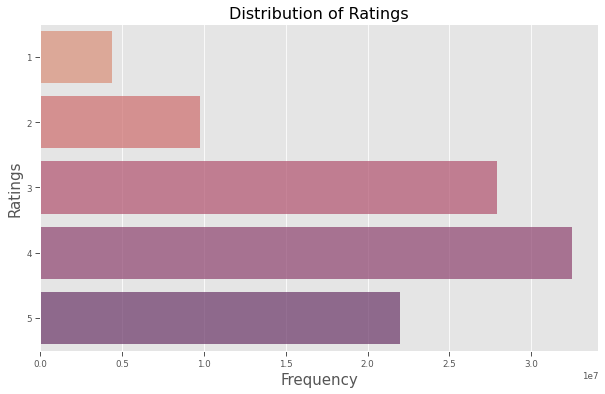

In [ ]:
fig, ax = plt.subplots(figsize = (10, 6))
plt.title('Distribution of Ratings', fontsize=16)
ax = sns.countplot(data = ratings_new, y = 'rating', palette = ('flare'), alpha = 0.7)
ax.set_xlabel('Frequency', fontsize = 15)
ax.set_ylabel('Ratings', fontsize = 15)
plt.show()

#### 2.0.2 Distribution of ratings across days of the week

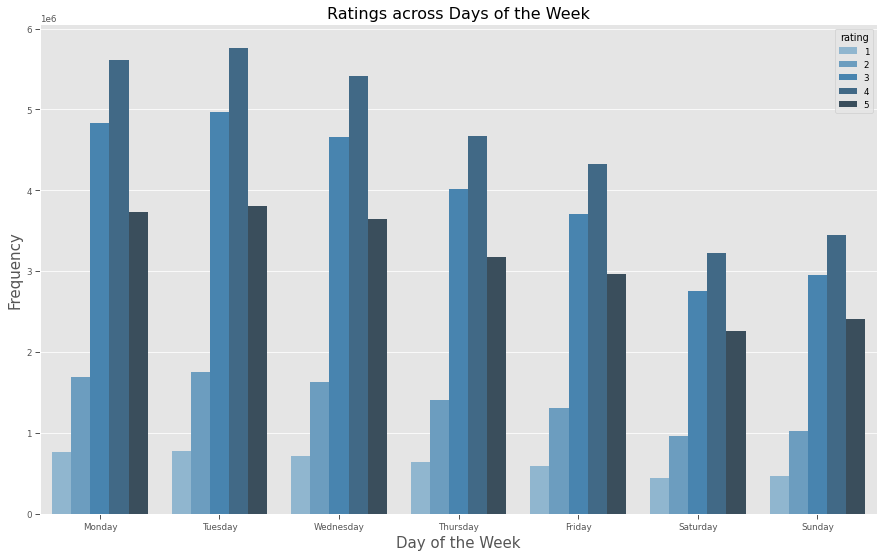

In [ ]:
fig, ax = plt.subplots(figsize = (15, 9))
plt.title('Ratings across Days of the Week', fontsize=16)
ax = sns.countplot(data = ratings_new, x = 'day', hue = 'rating', order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], 
                    palette = ('Blues_d'))
ax.set_xlabel('Day of the Week', fontsize = 15)
ax.set_ylabel('Frequency', fontsize = 15)
plt.show()

In [ ]:
ratings_new['rating'].groupby(ratings_new['day']).mean()

day
Friday       3.601840
Monday       3.593978
Saturday     3.610197
Sunday       3.611835
Thursday     3.600126
Tuesday      3.592138
Wednesday    3.600912
Name: rating, dtype: float64

#### 2.0.3 Data collection timeline

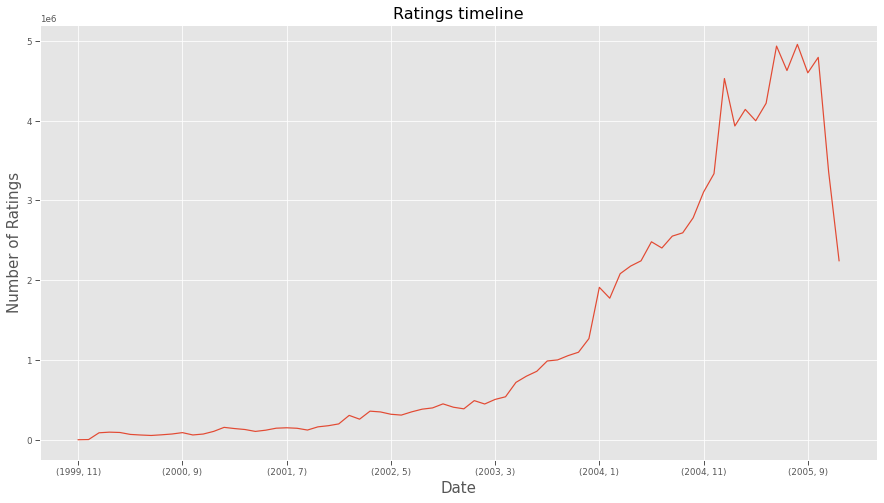

In [ ]:
style.use('ggplot')
sns.set_context('paper')

fig, ax = plt.subplots(figsize = (15, 8))
plt.title('Ratings timeline', fontsize=16)
#ax = ratings_new['rating'].groupby([ratings_new['date'].month, ratings_new['date'].year]).count().plot()
ax = ratings_new['rating'].groupby([ratings_new['date'].dt.year, ratings_new['date'].dt.month]).count().plot()
ax.set_xlabel('Date', fontsize = 15)
ax.set_ylabel('Number of Ratings', fontsize = 15)
plt.show()


#### 2.0.4 Ratings per User/Item distribution

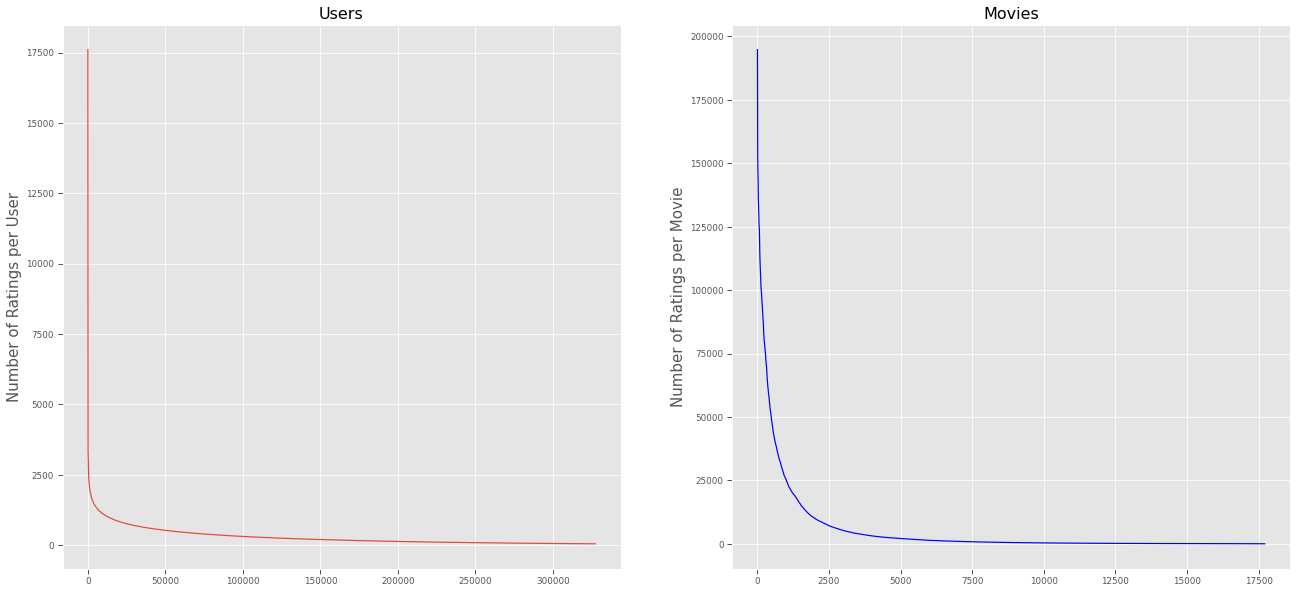

In [ ]:
ratings_per_user = ratings_new.groupby(by = 'customer')['rating'].count().sort_values(ascending = False)
ratings_per_movie = ratings_new.groupby(by = 'movie')['rating'].count().sort_values(ascending = False)

fig, ax = plt.subplots(figsize = (22, 10))
ax1 = plt.subplot(1,2,1)
plt.title('Users', fontsize=16)
#sns.kdeplot(ratings_per_user, shade=True, ax=ax1)
plt.plot(ratings_per_user.values)
plt.ylabel('Number of Ratings per User', fontsize = 15)

ax2 = plt.subplot(1,2,2)
plt.title('Movies', fontsize=16)
#sns.kdeplot(ratings_per_movie, shade=True, ax=ax2)
plt.plot(ratings_per_movie.values, 'b-')
plt.ylabel('Number of Ratings per Movie', fontsize = 15)

plt.show()


In [ ]:
quantiles_users = ratings_per_user.quantile(np.arange(0,1.01,0.05), interpolation='higher')
quantiles_movies = ratings_per_movie.quantile(np.arange(0,1.01,0.05), interpolation='higher')

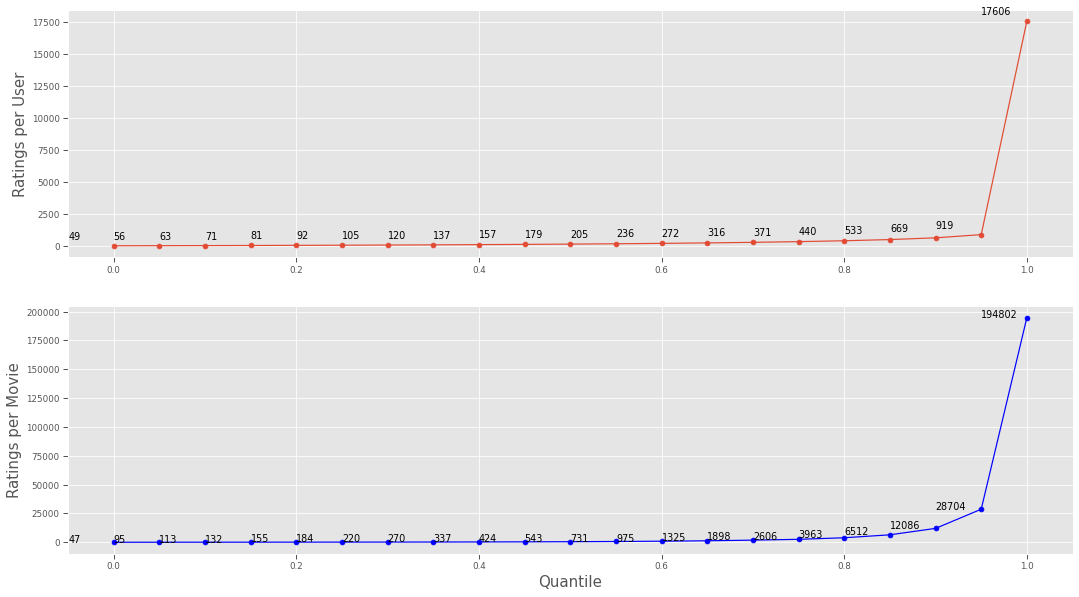

In [ ]:
plt.figure(figsize = (18, 10))


plt.title('Rating per Users/Movies - Quantiles', fontsize=15)
ax1 = plt.subplot(2,1,1)
ax1 = sns.lineplot(x = quantiles_users.index, y = quantiles_users.values) 
ax1.scatter(x = quantiles_users.index, y = quantiles_users.values)
plt.ylabel('Ratings per User', fontsize = 15)

for x,y in zip(quantiles_users.index[::1], quantiles_users[::1]):
    ax1.annotate(s = "{}".format(y), xy=(x,y), xytext=(x-0.05, y+500))


ax2 = plt.subplot(2,1,2)
ax2 = sns.lineplot(x = quantiles_movies.index, y = quantiles_movies.values, color = 'blue') 
ax2.scatter(x = quantiles_movies.index, y = quantiles_movies.values, color = 'blue')
plt.xlabel('Quantile', fontsize = 15)
plt.ylabel('Ratings per Movie', fontsize = 15)

for x,y in zip(quantiles_movies.index[::1], quantiles_movies[::1]):
    ax2.annotate(s = "{}".format(y), xy=(x,y), xytext=(x-0.05, y+100))
plt.show()




#### 2.1 Splitting the data-set
Splitting the data into 75% for training & 25% for testing. Since users can vote for the same movie multiple times, we will not randomly split. We will take the first 75% of the ratings for training. 

In [2]:
# Reloading the dataset 
from google.colab import drive
drive.mount('/content/drive')

ratings_new = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/netflix_ratings.csv', parse_dates = ['date'])
ratings_new.sort_values(by = ['date'], inplace = True)
ratings_new.head()

import math
thres = math.ceil(0.75*ratings_new.shape[0])

ratings_train = ratings_new.iloc[0:thres]
ratings_test = ratings_new.iloc[thres:]

Mounted at /content/drive


In [3]:
print(f'Before splitting shape : {ratings_new.shape}')
print(f'Training dataset shape : {ratings_train.shape}')
print(f'Test dataset shape : {ratings_test.shape}')

Before splitting shape : (96447729, 5)
Training dataset shape : (72335797, 5)
Test dataset shape : (24111932, 5)


In [4]:
train_sparse_matrix = sparse.csr_matrix((
        ratings_train.rating.values, (ratings_train.customer.values,ratings_train.movie.values)
    ))
test_sparse_matrix = sparse.csr_matrix((
        ratings_test.rating.values, (ratings_test.customer.values,ratings_test.movie.values)
    ))

In [5]:
print(f'Unique users in train data: {ratings_train.customer.nunique()}')
print(f'Unique movies in train data: {ratings_train.movie.nunique()}')

train_sparse_matrix.shape
matrix_size = train_sparse_matrix.shape[0]* train_sparse_matrix.shape[1]
non_zero_counts = len(train_sparse_matrix.nonzero()[0])
print(f'Sparsity : {100*(1 - non_zero_counts/matrix_size)}')

Unique users in train data: 277553
Unique movies in train data: 17173
Sparsity : 99.84636542816129


In [6]:
print(f'Unique users in test data: {ratings_test.customer.nunique()}')
print(f'Unique movies in test data: {ratings_test.movie.nunique()}')

test_sparse_matrix.shape
matrix_size = test_sparse_matrix.shape[0]* test_sparse_matrix.shape[1]
non_zero_counts = len(test_sparse_matrix.nonzero()[0])
print(f'Sparsity : {100*(1 - non_zero_counts/matrix_size)}')

Unique users in test data: 273917
Unique movies in test data: 17704
Sparsity : 99.94878847676173


#### 2.1.1 Sample sparse matrices
Since the overall training & test datasets are still too large to perform complex modelling, we will use a small non-overlapping sample data from training to fit our models & test them using a sample matrix from the test set. 

In [7]:
def get_sample_sparse_matrix(sparse_matrix, no_users, no_movies, verbose = True):
     # Get (row, col) and (rating) tuple from sparse_matrix.
    row_ind, col_ind, ratings = sparse.find(sparse_matrix)
    users = np.unique(row_ind)
    movies = np.unique(col_ind)

    print("Original Matrix: (users, movies) -- ({} {})".format(len(users), len(movies)))
    print("Original Matrix: Ratings -- {}\n".format(len(ratings)))

    # It's just to make sure to get same sample everytime we run this program & pick without replacement
    np.random.seed(15)
    sample_users = np.random.choice(users, no_users, replace=False)
    sample_movies = np.random.choice(movies, no_movies, replace=False)
    
    # Get the boolean mask of these sampled_items in originl row/col_inds.
    mask = np.logical_and(np.isin(row_ind, sample_users), np.isin(col_ind, sample_movies))
    
    sample_sparse_matrix = sparse.csr_matrix((ratings[mask], (row_ind[mask], col_ind[mask])),
         shape=(max(sample_users)+1, max(sample_movies)+1))

    if verbose:
        print("Sampled Matrix : (users, movies) -- ({} {})".format(len(sample_users), len(sample_movies)))
        print("Sampled Matrix : Ratings --", format(ratings[mask].shape[0]))

    return sample_sparse_matrix

In [8]:
sample_train_sparse_matrix = get_sample_sparse_matrix(train_sparse_matrix, no_users = 10000, no_movies = 1000, verbose = True)
print()
sample_test_sparse_matrix = get_sample_sparse_matrix(test_sparse_matrix, no_users = 2000, no_movies = 200, verbose = True)

Original Matrix: (users, movies) -- (277553 17173)
Original Matrix: Ratings -- 72335797

Sampled Matrix : (users, movies) -- (10000 1000)
Sampled Matrix : Ratings -- 160104

Original Matrix: (users, movies) -- (273917 17704)
Original Matrix: Ratings -- 24111932

Sampled Matrix : (users, movies) -- (2000 200)
Sampled Matrix : Ratings -- 2435


In [9]:
sample_train_users, sample_train_movies, sample_train_ratings = sparse.find(sample_train_sparse_matrix)
reg_train = pd.DataFrame(
    {'customer': sample_train_users,
     'movie': sample_train_movies,
     'rating': sample_train_ratings
    })
print(reg_train.customer.nunique())
print(reg_train.movie.nunique())
print(reg_train.shape)
  

9630
971
(160104, 3)


In [10]:
sample_test_users, sample_test_movies, sample_test_ratings = sparse.find(sample_test_sparse_matrix)
reg_test = pd.DataFrame(
    {'customer': sample_test_users,
     'movie': sample_test_movies,
     'rating': sample_test_ratings
    })
print(reg_test.customer.nunique())
print(reg_test.movie.nunique())
print(reg_test.shape)

897
176
(2435, 3)


In [11]:
# Reading in the movies.csv file which contains data on the movie titles
movies = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/movie_titles.csv', names = ['id', 'year', 'title'], encoding = "ISO-8859-1",
                     header = None)
movies.head()

,id,year,title
0,1,2003.0,Dinosaur Planet
1,2,2004.0,Isle of Man TT 2004 Review
2,3,1997.0,Character
3,4,1994.0,Paula Abdul's Get Up & Dance
4,5,2004.0,The Rise and Fall of ECW


In [12]:
reg_train = reg_train.merge(movies, how = 'left', left_on='movie', right_on ='id')
reg_test = reg_test.merge(movies, how = 'left', left_on='movie', right_on ='id')

print(f'Number of missing movie titles in train data: {reg_train.title.isna().sum()}')
print(f'Number of missing movie titles in test data: {reg_test.title.isna().sum()}')

Number of missing movie titles in train data: 0
Number of missing movie titles in test data: 0


#### 2.1.2 Preparing data for Surprise library format
At the end of the day, recommendation systems can be intuitively thought of as training the known ratings in order to predict the unknown ratings as accurate as possible.   
We will be using surprise library in Python to perform KNN & matrix factorization methods to predict the unknown ratings

In [13]:
!pip install scikit-surprise

     |████████████████████████████████| 11.8 MB 6.3 MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp37-cp37m-linux_x86_64.whl size=1619425 sha256=590ea0820e3b9c39013b7c7b7471218e2a96cdd67626b2e5e3488fb946ff52b7
  Stored in directory: /root/.cache/pip/wheels/76/44/74/b498c42be47b2406bd27994e16c5188e337c657025ab400c1c
Successfully built scikit-surprise


In [14]:
from surprise import Reader, Dataset
from surprise.model_selection import cross_validate, train_test_split

reader = Reader(rating_scale=(1,5))
trainset = Dataset.load_from_df(reg_train[['customer', 'title', 'rating']], reader)
testset = Dataset.load_from_df(reg_test[['customer', 'title', 'rating']], reader)
# Building full trainset which contains global averages, average ratings of users & items in order to generate the bias term in
train_set = trainset.build_full_trainset()
test_set = testset.build_full_trainset()

### 3 Non-parametric similarities (KNN inspired methods)
In a collaborative filtering, we can leverage the similarity between items or between users to identify neighbours. This is often referred as non-parametric method since there are no parameters to be optimized/estimated. In this project, we will using the surprise library & its modules since it offers flexibility of KNN inspired methods & similarities measures.  

In these groups of methods, we identify k-nearest neighbours to our target user (or item) & aggregate their weighted ratings for items based on the similarity metric. Some of the most common metrics are given below:


*   Euclidean distance - Captures the Euclidean distance between two vectors (items or users represented in a space) 
*   Cosine Similarity - The angle between two vectors; used when we need to compare items with different norms 
*   Adjusted cosine - Normalizes the dot product using mean ratings per user. (Useful for user-user similarities) 
*   Pearson similarity - Instead of normalizing using mean ratings for each user, it leverages averaging ratings across all users for a particular item (Useful for item-item similarities)

All these metrics more or less suffer from the curse of dimensionality in a very sparse metrics where similar users are hard to find. But, cosine similarity offers the best bet. The prediction for an unknown user in this method is estimated by:


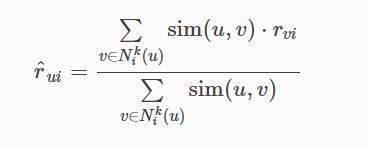

where u is the unknown user while v represents the k-nearest neighbours. sim(u,v) is the similarity measure between the users as mentioned above. The same formula can be tweaked for item-item similarities. 

For detailed documentation of the surprise modules on k-NN inspired models, check out https://buomsoo-kim.github.io/recommender%20systems/2020/09/06/Recommender-systems-collab-filtering-8.md/


#### 3.1 KNN Basic
In the simplest form, the similarity metric between all users are calculated using their raw ratings for movies. Here, we have used cosine as our metric & fixed user_based as True. If we wish to change the method to estimate similarities between items, we can do it by tweaking the parameter to False. 



In [35]:
RMSE = []
MAE = []

from surprise import KNNBasic, KNNWithMeans, KNNWithZScore, KNNBaseline
sim_options = {'name': 'cosine','user_based': 'True'}
knn_list = [30, 40, 50, 60, 70, 80]
cv_results = []
for k in knn_list:
  clf = KNNBasic(k= k, sim_options = sim_options)
  results = cross_validate(clf, trainset, measures=['RMSE', 'MAE'], cv=3, verbose=False)
  temp = pd.DataFrame.from_dict(results).mean(axis=0)
  RMSE.append(temp['test_rmse'])
  MAE.append(temp['test_mae'])

knnbasic_summary = pd.DataFrame(
    {'k': knn_list,
     'RMSE': RMSE,
     'MAE': MAE
     })

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing th

#### 3.2 KNN Z Score
In a real world, the simple KNN method might not work well since users's rating is quite subjective & cannot be compared. For example, I tend to be very choosy about movies so only my favorite 5 movies will get 5/5 while someone else might be very lenient with his ratings.  
An effective way to consider these differences is by rate centerization & normalization using Surprise models KNNMeans() & KNNZScore(). KNNMeans centers the raw ratings using the mean ratings for users while Zscore goes one step further to normalize it. 

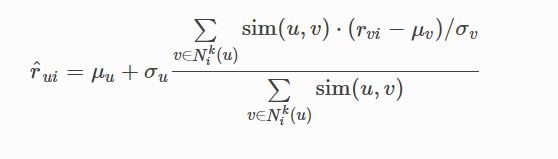

In [36]:
RMSE = []
MAE = []
cv_results = []

for k in knn_list:
  clf = KNNWithZScore(k= k, sim_options = sim_options)
  results = cross_validate(clf, trainset, measures=['RMSE', 'MAE'], cv=3, verbose=False)
  temp = pd.DataFrame.from_dict(results).mean(axis=0)
  RMSE.append(temp['test_rmse'])
  MAE.append(temp['test_mae'])

knnzscore_summary = pd.DataFrame(
    {'k': knn_list,
     'RMSE': RMSE,
     'MAE': MAE
     })

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing th

#### 3.3 KNN with baseline estimates  
Going one step further, KNN with baseline estimates combines both user & item biases in the final prediction. So, a tough user's ratings might get pushed down while a popular hit film such as Intersteller might get its ratings bumped up owing to its high average rating.   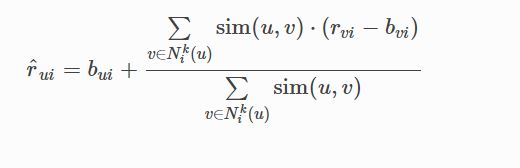


In [37]:
RMSE = []
MAE = []
cv_results = []

for k in knn_list:
  clf = KNNBaseline(k= k, sim_options = sim_options)
  results = cross_validate(clf, trainset, measures=['RMSE', 'MAE'], cv=3, verbose=False)
  temp = pd.DataFrame.from_dict(results).mean(axis=0)
  RMSE.append(temp['test_rmse'])
  MAE.append(temp['test_mae'])

knnbaseline_summary = pd.DataFrame(
    {'k': knn_list,
     'RMSE': RMSE,
     'MAE': MAE
     })

Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Comput

#### 3.4 Choosing the optimum number of neighbours 


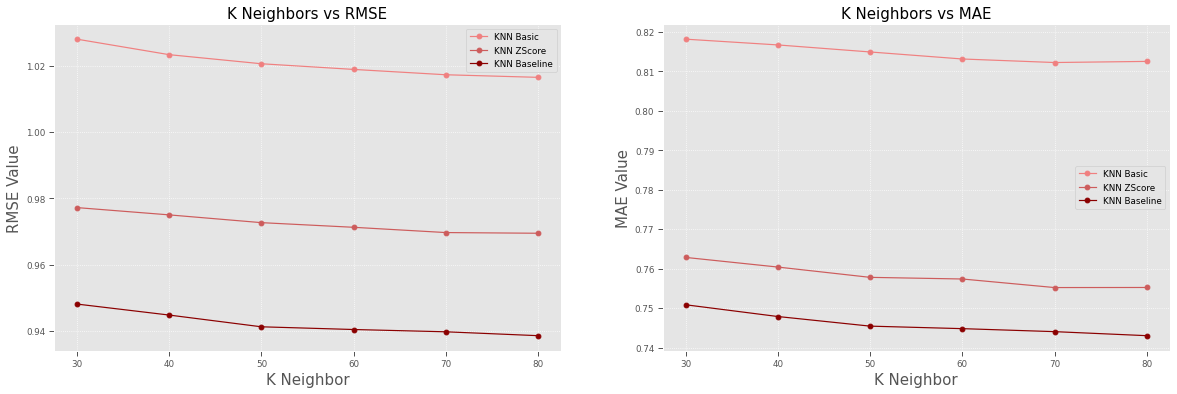

In [40]:
style.use('ggplot')
sns.set_context('paper')

plt.figure(figsize=(20,6))

plt.subplot(1, 2, 1)
plt.title('K Neighbors vs RMSE', loc='center', fontsize=15)
plt.plot(knnbasic_summary['k'], knnbasic_summary['RMSE'], label='KNN Basic', color='lightcoral', marker='o')
plt.plot(knnzscore_summary['k'], knnzscore_summary['RMSE'], label='KNN ZScore', color='indianred', marker='o')
plt.plot(knnbaseline_summary['k'], knnbaseline_summary['RMSE'], label='KNN Baseline', color='darkred', marker='o')
plt.xlabel('K Neighbor', fontsize=15)
plt.ylabel('RMSE Value', fontsize=15)
plt.legend()
plt.grid(ls='dotted')

plt.subplot(1, 2, 2)
plt.title('K Neighbors vs MAE', loc='center', fontsize=15)
plt.plot(knnbasic_summary['k'], knnbasic_summary['MAE'], label='KNN Basic', color='lightcoral', marker='o')
plt.plot(knnzscore_summary['k'], knnzscore_summary['MAE'], label='KNN ZScore', color='indianred', marker='o')
plt.plot(knnbaseline_summary['k'], knnbaseline_summary['MAE'], label='KNN Baseline', color='darkred', marker='o')
plt.xlabel('K Neighbor', fontsize=15)
plt.ylabel('MAE Value', fontsize=15)
plt.legend()
plt.grid(ls='dotted')

plt.show()

Based on the results, both RMSE & MAE are significantly lower for Baseline as compared to KNNZscore & KNNBasic. For Basic & Zscore, the MAE slighly increases when k-neighbours change from 70 to 80. So, we will fix the optimum k as 70 for these two methods.

### 4.0 Matrix Factorization methods
In real world, using memory based approach will be too time-consuming, especially in a very sparse matrix with a lot of users & items. Matrix factorization offers a way out through its dimensionality reduction method. The most famous algorithm is the one Simon Funk used for the original Netflix Prize competition in 2009.  
SVD or Singular Vector Decomposition reduces the ratings matrix into pre-established k number of latent features. While in real implementation, latent features don't carry any meaning, it can be intuitively interpreted as features such as genre, number of awards, duration, time-period, actors etc

SVD is just a fancy word to decompose a user-item vector into components along axes which carries the most information. Matrix U contains the user-latent feature relationship, which can be considered as the normalized representation of users in the changed principal axes. Matrix V contains the item-latent feature relationship.

In [ ]:
from surprise import SVD, SVDpp, NMF, NormalPredictor
from surprise.model_selection import GridSearchCV

param_grid = {'n_factors':[50,100], 'lr_all':[0.005,0.01],'reg_all':[0.02,0.1]}
gs = GridSearchCV(SVD, param_grid, measures=['rmse' , 'mae'], cv = 5)
gs.fit(trainset)
params_svd = gs.best_params['rmse']

#### 4.2 SVD++
SVDpp is an extention of the simple SVD algorithm, where we also consider the implicit ratings of users. That is, irrespective of the actual rating,  propensity is considered if the user takes the effort to rate. It is a binary matrix where any explicit rating is given 1 & no rating is given 0. 

In [ ]:
from surprise import SVDpp
gs = GridSearchCV(SVDpp, param_grid, measures=['rmse' , 'mae'], cv = 5)
gs.fit(trainset)
params_svdpp = gs.best_params['rmse']

#### 4.3 NMF (Non-Negative Matrix Factorization)
NMF is an extension to the normal MF with an added constraint that all weights in the latent matrix should be positive. The initial weights are randomly assigned & the cost function i.e difference between actual rating & predicted (dot product of user-latent matrix U & product-latent matrix V) is optimized using ALS/SGD.

In [ ]:
from surprise import NMF
param_grid = {'n_factors':[30,50], 'reg_pu':[0.05, 0.2],'reg_qi':[0.05, 0.2], 'biased' : [True]}
gs = GridSearchCV(NMF, param_grid, measures=['rmse' , 'mae'], cv = 5)
gs.fit(trainset)
params_nmf = gs.best_params['rmse']

In [ ]:
print(params_svd)
print(params_svdpp)
print(params_nmf)

{'n_factors': 100, 'lr_all': 0.01, 'reg_all': 0.1}
{'n_factors': 50, 'lr_all': 0.005, 'reg_all': 0.02}
{'n_factors': 30, 'reg_pu': 0.05, 'reg_qi': 0.2, 'biased': True}


### 5.0 Comparing the performance of all algorithms

In [42]:
estimator_list = {
    'SVD' : SVD(), 'Tuned SVD' : SVD(n_factors=100, lr_all=0.01, reg_all=0.1) ,
  'SVD++' : SVDpp(), 'Tuned SVD++' : SVDpp(n_factors=50, lr_all=0.005, reg_all=0.02),
  'NMF': NMF(biased = True), 'Tuned NMF': NMF(n_factors=30, reg_pu=0.05, reg_qi = 0.2, biased = True),
  'KNN Basic' : KNNBasic(k = 70, sim_options = sim_options),
  'KNN ZScore' : KNNWithZScore(k = 70, sim_options = sim_options),
  'KNN Baseline' : KNNBaseline(k = 80, sim_options = sim_options)
  }

In [43]:
estimator_name = []
RMSE = []
MAE = []
run_time = []

for name, estimator in estimator_list.items():
  # Perform cross validation
  print(f'{name}: Evaluating the algorithm')
  results = cross_validate(estimator, trainset, measures=['RMSE', 'MAE'], cv=5, verbose=False)
  # Get results & append algorithm name
  temp = pd.DataFrame.from_dict(results).mean(axis=0)
  estimator_name.append(name)
  RMSE.append(temp['test_rmse'])
  MAE.append(temp['test_mae'])
  run_time.append(temp['fit_time']+ temp['test_time'])
  print('Appended the results to the list')
  print('')

SVD: Evaluating the algorithm
Appended the results to the list

Tuned SVD: Evaluating the algorithm
Appended the results to the list

SVD++: Evaluating the algorithm
Appended the results to the list

Tuned SVD++: Evaluating the algorithm
Appended the results to the list

NMF: Evaluating the algorithm
Appended the results to the list

Tuned NMF: Evaluating the algorithm
Appended the results to the list

KNN Basic: Evaluating the algorithm
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Appended the results to the list

KNN ZScore: Evaluating the algorithm
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity

In [49]:
evaluation_summary = pd.DataFrame(
    {'name': estimator_name,
     'RMSE': RMSE,
     'MAE': MAE,
     'run_time' : run_time
    })
evaluation_summary = evaluation_summary.sort_values(by = 'RMSE', ascending = True)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
No handles with labels found to put in legend.
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
No handles with labels found to put in legend.


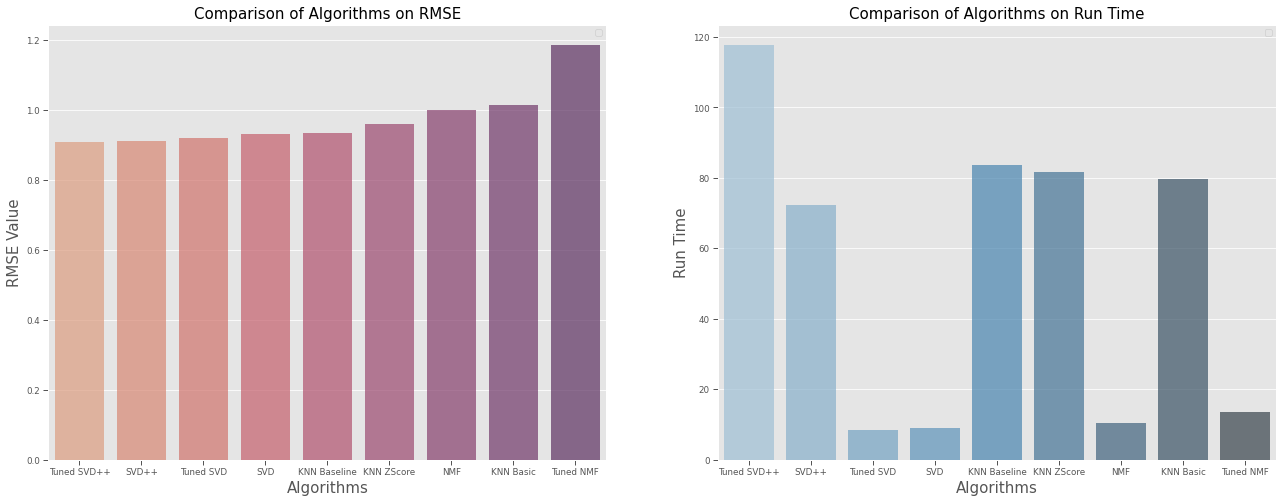

In [55]:
plt.figure(figsize=(22,8))

plt.subplot(1, 2, 1)
plt.title('Comparison of Algorithms on RMSE', loc='center', fontsize=15)
sns.barplot(evaluation_summary['name'], evaluation_summary['RMSE'], palette = ('flare'), alpha = 0.7)
plt.xlabel('Algorithms', fontsize=15)
plt.ylabel('RMSE Value', fontsize=15)
plt.legend()
#plt.grid(ls='dashed')

plt.subplot(1, 2, 2)
plt.title('Comparison of Algorithms on Run Time', loc='center', fontsize=15)
sns.barplot(evaluation_summary['name'], evaluation_summary['run_time'], palette = ('Blues_d'), alpha = 0.7)
plt.xlabel('Algorithms', fontsize=15)
plt.ylabel('Run Time', fontsize=15)
plt.legend()
#plt.grid(ls='dashed')

plt.show()

The RMSE & MAE are quite comparable between the SVD, SVD++ & KNN Baseline models. But the run times for SVD++ & KNN Baseline is considerably higher than the tuned SVD model. So, we will finalize that for our movie recommendations below.

### 6.0 Fitting the best model


In [ ]:
SVD_model = SVD(n_factors=100, lr_all=0.01, reg_all=0.1)
SVD_model.fit(train_set)

In [ ]:
print(f'User Matrix : {SVD_model.pu.shape}')
print(f'Item Matrix : {SVD_model.qi.shape}')

User Matrix : (9630, 100)
Item Matrix : (968, 100)


In [ ]:
item_to_row_idx = SVD_model.trainset._raw2inner_id_items
sample_movie_idx = item_to_row_idx['Rush']
print(SVD_model.qi[sample_movie_idx])
print()
print(f'Every movie has {SVD_model.qi.shape[1]} features')

[ 0.06229582 -0.23386904  0.04594682  0.04187504 -0.04905126 -0.01731602
  0.11739064  0.1428666  -0.21078253  0.11240757  0.00905379  0.03790488
  0.10487769  0.16061873 -0.02474254  0.01947208 -0.13848641  0.12642823
  0.09828068  0.04731961  0.02700377  0.10288509  0.14650199  0.07595012
  0.00842124 -0.05072413  0.18569401 -0.2927235   0.09541158  0.08703645
  0.10812333  0.10419208  0.01301197  0.00714887  0.04221588 -0.07093273
  0.00563478  0.44010134 -0.04973354  0.08811065 -0.12594713  0.18075581
  0.05688564 -0.15189352  0.25147293 -0.14608233 -0.11910114  0.19289764
 -0.11691051  0.03008267 -0.03731425  0.15337359  0.17711738 -0.02520261
  0.07641342  0.17384604  0.25703695  0.10974888 -0.04329939  0.11396502
 -0.01243382 -0.03274702  0.13285335  0.15075355 -0.01612277  0.08978166
  0.03497371  0.06437549 -0.052698    0.01740074 -0.02443024 -0.13796928
  0.07283742 -0.20008586  0.16093873  0.08089216  0.07519953 -0.06747108
 -0.06121063 -0.00430743 -0.2288023  -0.17574847 -0

In [ ]:
# Testing the predict API function in Surprise library
SVD_model.predict('870526', '8 Man')

Prediction(uid='870526', iid='8 Man', r_ui=None, est=3.427756834835953, details={'was_impossible': False})

#### 6.1 Movie Recommendations

In [ ]:
from scipy.spatial.distance import cosine as cosine_distance

def display(similarity_table, n_rows):
    similarity_table = pd.DataFrame(
        similarity_table,
        columns=['cosine distance', 'movie title']
    ).sort_values('cosine distance', ascending=True)
    return similarity_table.iloc[1:n_rows+1]
    
def get_top_recommendations(movie_title, model, n_rows):
    """Returns the top 5 most similar movies to a specified movie """
    
    # Get the first movie vector
    movie_idx = item_to_row_idx[movie_title]
    movie_vector = SVD_model.qi[movie_idx]
    similarity_table = []
    
    # Iterate over every possible movie and calculate similarity
    for other_movie_title in model.trainset._raw2inner_id_items.keys():
        other_movie_idx = item_to_row_idx[other_movie_title]
        other_movie_vector = SVD_model.qi[other_movie_idx]
        
        # Get the second movie vector, and calculate distance
        similarity_score = cosine_distance(other_movie_vector, movie_vector)
        similarity_table.append((similarity_score, other_movie_title))
    
    # sort movies by ascending similarity
    return display(similarity_table, n_rows)

In [ ]:
get_top_recommendations('Rush', SVD_model, 5)

,cosine distance,movie title
5,0.688308,The Great Race
541,0.723596,Hercules: The Legendary Journeys: Season 5
339,0.733286,Dr. Jekyll & Mr. Hyde: 1932 & 1941
244,0.735264,Cannibal Ferox
915,0.752674,Dragon Ball: The Saga of Goku


### 7.0 Wrapping up
In this experiment, we looked at the most common collaborative techniques used in recommender systems including memory based K-Nearest Neighbours for user-user similarities, matrix factorization methods to train latent feature matrices using SGD/ALS & deep neural networks.  
Even with a small sample of the actual data (10000 users & 1000 items), the runtimes were considerably high for training. A lot of focus goes into optimizing the run times in order to efficiently recommend from a larger corpus of items.

Additional reading:


1.   SVD Intuition : https://towardsdatascience.com/svd-8c2f72e264f
2.   Surprise Models : https://bmanohar16.github.io/blog/recsys-evaluation-in-surprise
3. Collaborative filtering : https://towardsdatascience.com/various-implementations-of-collaborative-filtering-100385c6dfe0
4. Matrix Factorization using Surprise : https://towardsdatascience.com/building-and-testing-recommender-systems-with-surprise-step-by-step-d4ba702ef80b


